In [6]:
import pandas as pd
import numpy as np

In [7]:
import sys
sys.path

['/Users/jr/Desktop/1006_Capstone/Capstone-Topic-Modeling/LDA',
 '/Users/jr/anaconda3/lib/python37.zip',
 '/Users/jr/anaconda3/lib/python3.7',
 '/Users/jr/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/Users/jr/.local/lib/python3.7/site-packages',
 '/Users/jr/anaconda3/lib/python3.7/site-packages',
 '/Users/jr/anaconda3/lib/python3.7/site-packages/aeosa',
 '/Users/jr/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/Users/jr/.ipython']

In [22]:
data = pd.read_csv('../data/10000.csv')
data.head()

,url,extracted_content,timestamp
0,https://www.rd.com/health/wellness/life-coache...,Charlotte Hilton Andersen Dec 19 You’re not re...,2019-03-08 09:53:05.567228
1,https://partners.magento.com/portal/customer/a...,Login or Create an Account If you have an acco...,2019-06-13 17:40:44.757068
2,https://yahoo.brand.edgar-online.com/DisplayFi...,Last Trade: $0.17 Change: 0.00 (0.00%) Trade T...,2019-03-28 19:04:32.921537
3,https://www.forbes.com/sites/alejandrocremades...,"He Sold His First Startup To Yahoo, His Second...",2019-06-14 12:26:40.624181
4,https://www.bloomberg.com/research/stocks/priv...,"April 19, 2019 3:34 AM ET Company Overview of ...",2019-04-19 07:34:13.488132


In [9]:
print(data['extracted_content'][1])

Login or Create an Account If you have an account with us, log in using your email address. New Customers By creating an account with our store, you will be able to move through the checkout process faster, store multiple shipping addresses, view and track your orders in your account and more.


In [23]:
documents = data[['extracted_content']]
documents['index'] = documents.index
print(documents.shape)
documents.head()

(10000, 2)


/Users/jr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,extracted_content,index
0,Charlotte Hilton Andersen Dec 19 You’re not re...,0
1,Login or Create an Account If you have an acco...,1
2,Last Trade: $0.17 Change: 0.00 (0.00%) Trade T...,2
3,"He Sold His First Startup To Yahoo, His Second...",3
4,"April 19, 2019 3:34 AM ET Company Overview of ...",4


# use spacy to tokenize

In [11]:
import spacy
import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm') #en_core_web_sm
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text.lower() for token in tokens if (token.text not in punctuations)]

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

tokens, all_tokens = tokenize_dataset(list(documents['extracted_content']))

In [19]:
import pickle as pkl
# pkl.dump(tokens, open("data/sent_tokens.p", "wb"))
# pkl.dump(all_tokens, open("data/all_tokens.p", "wb"))
all_tokens = pkl.load(open("../data/all_tokens.p", "rb"))
tokens = pkl.load(open("../data/sent_tokens.p", "rb"))

In [11]:
assert len(tokens)==10000

In [15]:
len(all_tokens)

3783284

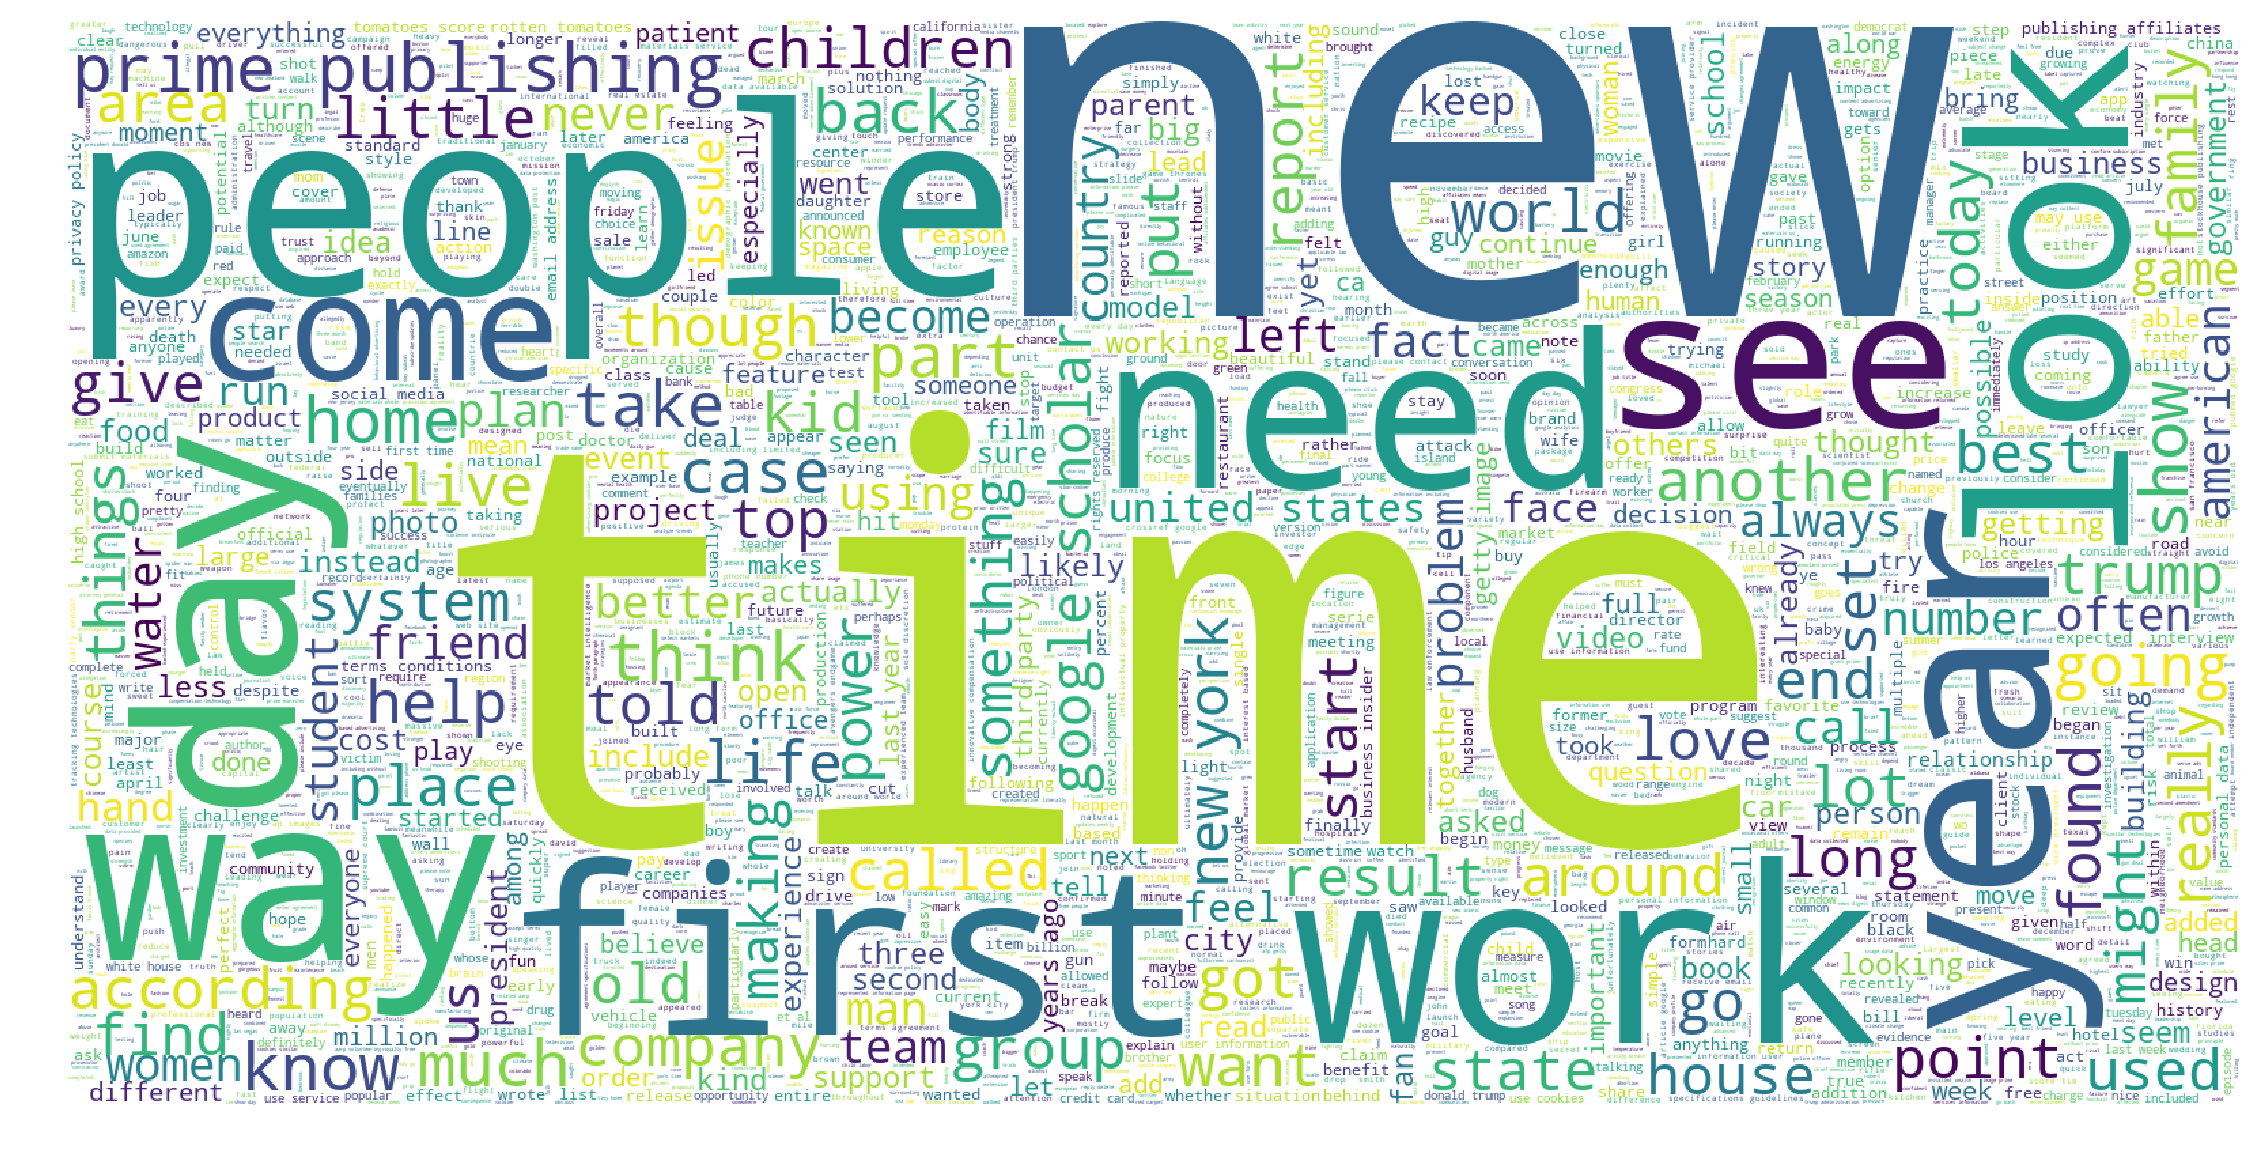

In [26]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
# from nltk.corpus import stopwords
# stops = set(stopwords.words('english'))

# all_tokens = [word for word in all_tokens if word not in stops and word.isalpha() ] 

# Import the wordcloud library
from wordcloud import WordCloud,STOPWORDS
# Join the different processed titles together.
long_string = ','.join(list(all_tokens))

stopwords = set(STOPWORDS)
stopwords.update(["one", "two", "say", "said",'says', "well",'even','make','made','great','good','many','still','thing'])

# Create a WordCloud object
wordcloud = WordCloud(width=1600, height=800,background_color="white", max_words=5000, stopwords=stopwords,contour_width=0, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
# wordcloud.to_image()
# wordcloud.to_file("../img/wordcloud.jpg")
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('../img/wordcloud.png', bbox_inches='tight')

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

n_features = 15000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.01, max_features=n_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents['extracted_content'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(analyzer='word',
                                max_df=0.95, min_df=2, 
                                max_features=n_features,  #max number of unique words
                                stop_words='english',
                                lowercase=True,
                                token_pattern='[a-zA-Z]{3,}') #num chars>3
tf = tf_vectorizer.fit_transform(documents['extracted_content'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [25]:
# Materialize the sparse data
data_dense = tf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.1984626666666667 %


In [26]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

# n_topics = 20

# Run NMF
# nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Build LDA Model
lda_model = LatentDirichletAllocation(batch_size=128,            # n docs in each learning iter
                                      learning_decay=0.8,
                                      n_components= 25,         # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',
                                      learning_offset=10,
                                      max_doc_update_iter=100,
                                      random_state=100,          # Random state           
                                      evaluate_every = -1,       # set it to 0 or negative number to not evalute perplexity in training at all. 
                                      n_jobs = -1,               # Use all available CPUs
                                     )

lda_output = lda_model.fit_transform(tf)
print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.8,
             learning_method='online', learning_offset=10,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=25, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [27]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
# display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
said trump president police state law court government house people
Topic 1:
email free use com facebook online check app account site
Topic 2:
images photo getty women dress royal red year prince twins
Topic 3:
insurance price savings chart coverage time product average date return
Topic 4:
power used control systems use using performance technology design test
Topic 5:
new film series season like time star man fans movie
Topic 6:
prime publishing materials agreement affiliates service images rights submit image
Topic 7:
food recipe make chicken use add sugar like cup ingredients
Topic 8:
information data use services service cookies personal advertising google user
Topic 9:
water earth land climate solar wind weather river said area
Topic 10:
data company students update school information job education board university
Topic 11:
said children year people death family years old child according
Topic 12:
com gun ammoland rifle people information reply free thatsthem pistol
To

In [28]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(tf))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -25177380.124987893
Perplexity:  3098.370576365613
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.8, 'learning_method': 'online', 'learning_offset': 10, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 25, 'n_jobs': -1, 'n_topics': None, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


## visualize clustered documents 

In [3]:
import matplotlib
print(matplotlib.__version__)

3.1.2


Component's weights: 
 [[ 0.57  0.32  0.1   0.04  0.05  0.32  0.02  0.07  0.04  0.04  0.07  0.2
   0.04  0.04  0.02  0.05  0.37  0.06  0.02  0.04  0.04  0.34  0.32  0.16
   0.06]
 [ 0.72 -0.61 -0.03 -0.04 -0.06 -0.2  -0.01 -0.06 -0.05 -0.01 -0.04  0.06
  -0.01 -0.02 -0.01  0.   -0.11 -0.04 -0.01 -0.01 -0.03 -0.1  -0.14 -0.14
   0.01]]
Perc of Variance Explained: 
 [0.03 0.12]


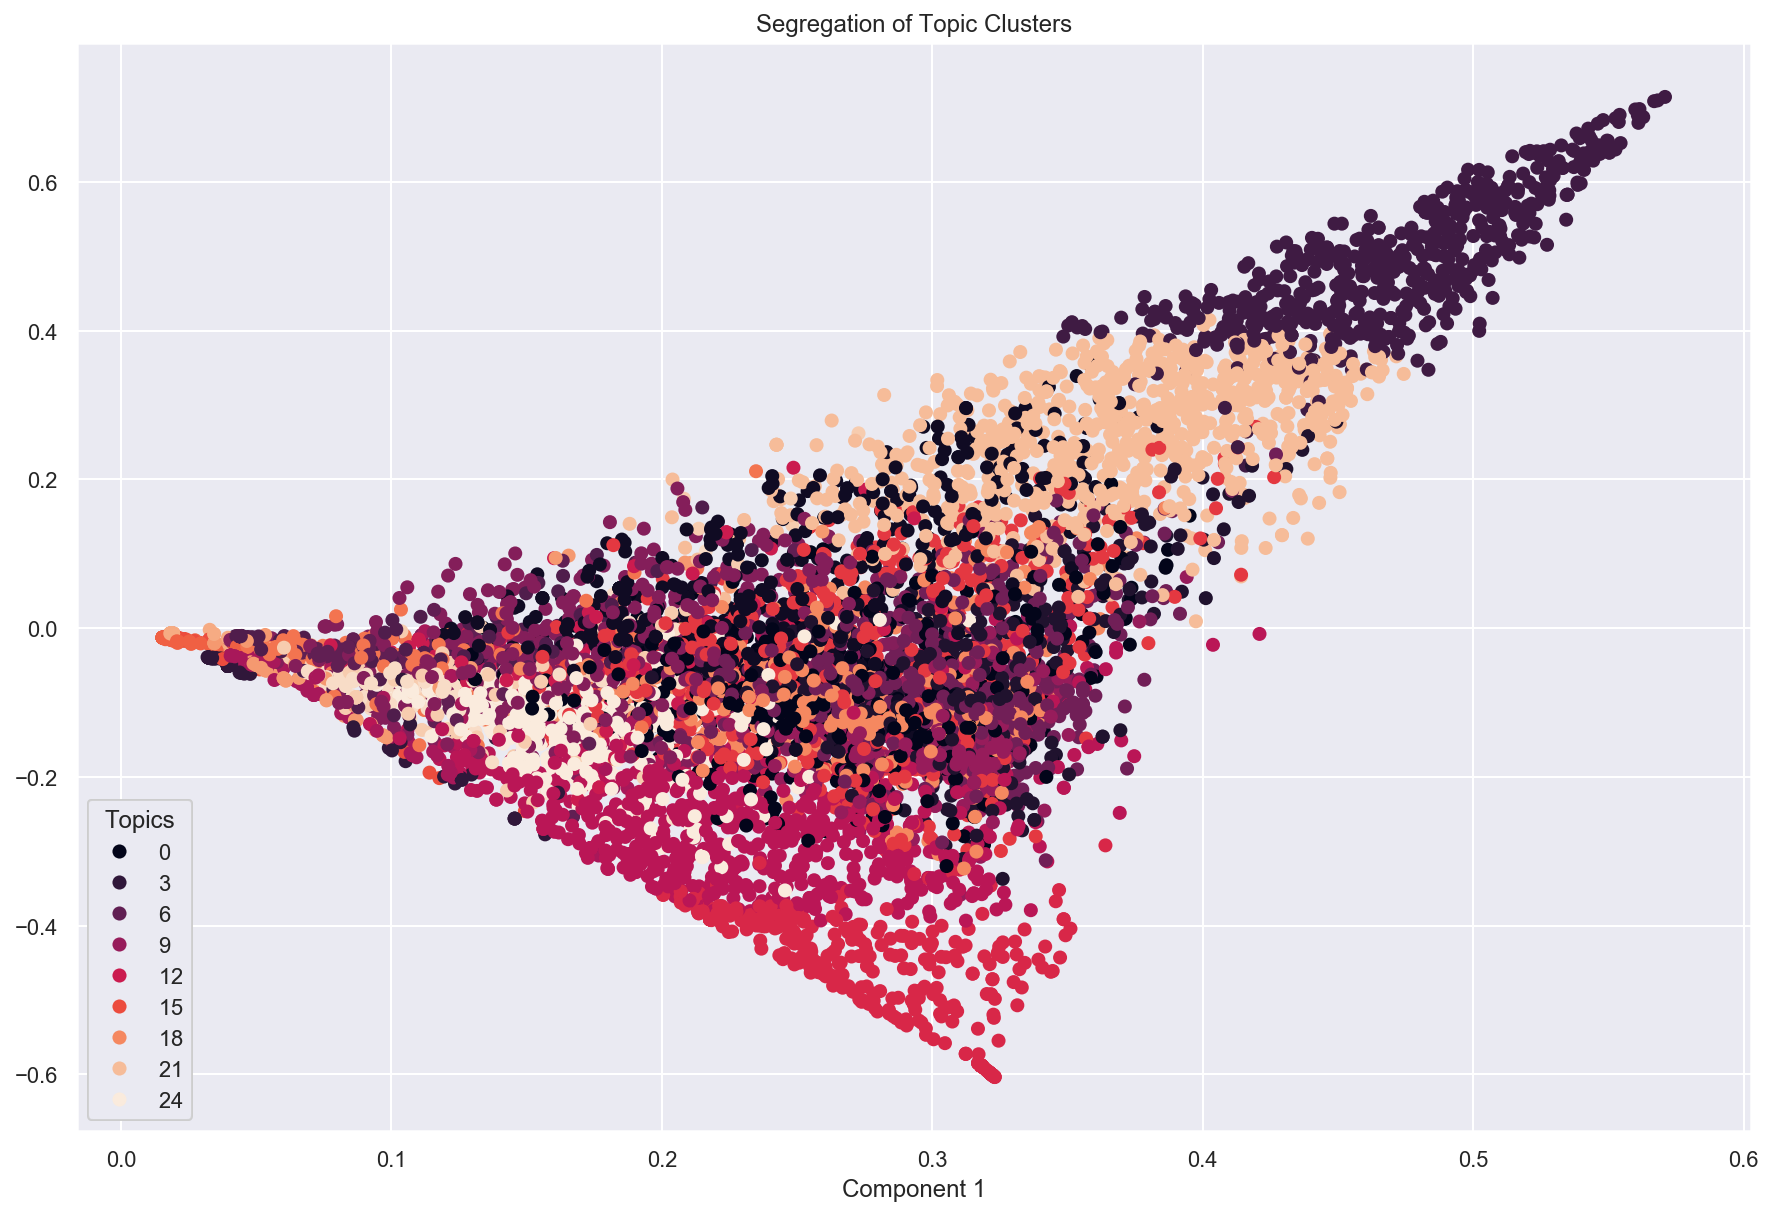

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
# Construct the k-means clusters
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=25, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

# Plot

fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(x, y, c=clusters)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),loc="lower left", title="Topics")
ax.add_artist(legend1)


# plt.scatter(x, y, c=clusters,label=clusters)
# plt.legend()
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters")
plt.savefig('../img/topic_clusters.jpg')
plt.show()

In [33]:
from sklearn.model_selection import GridSearchCV
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25], 'learning_decay': np.arange(0.2,1.,0.2)}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf)

/Users/jr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

In [34]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf))

Best Model's Params:  {'learning_decay': 0.8, 'n_components': 25}
Best Log Likelihood Score:  -3319764.39223834
Model Perplexity:  499.6951231572212


In [51]:
model.cv_results_

{'mean_fit_time': array([1313.52247691,   40.03579998,   39.35507758,   42.93461005,
          38.29991404,   39.70545427,   40.05105146,   41.88351623,
          37.71464912,   40.13272341,   39.68459741,   43.10646963,
          39.3213652 ,   40.79599396,   42.53110139,   44.3871967 ]),
 'std_fit_time': array([1.80575568e+03, 1.27290037e+00, 6.37947514e-01, 8.35683366e-01,
        3.49592350e-01, 1.08646883e+00, 6.19966316e-01, 5.31538794e-01,
        2.13040356e-01, 1.44389346e-01, 7.88125877e-01, 6.83347535e-01,
        9.07116573e-01, 9.09748802e-01, 2.34450988e+00, 1.04770081e+00]),
 'mean_score_time': array([1.47726266, 1.58068109, 1.57788221, 1.68964434, 1.48388934,
        1.57686234, 1.55419771, 1.68355242, 1.45424199, 1.62242897,
        1.56392829, 1.71197565, 1.55287671, 1.63298845, 1.70486418,
        1.81418268]),
 'std_score_time': array([0.04970912, 0.12487851, 0.00755291, 0.03424504, 0.03324266,
        0.0975604 , 0.06807268, 0.06271102, 0.05902353, 0.02578363,
    

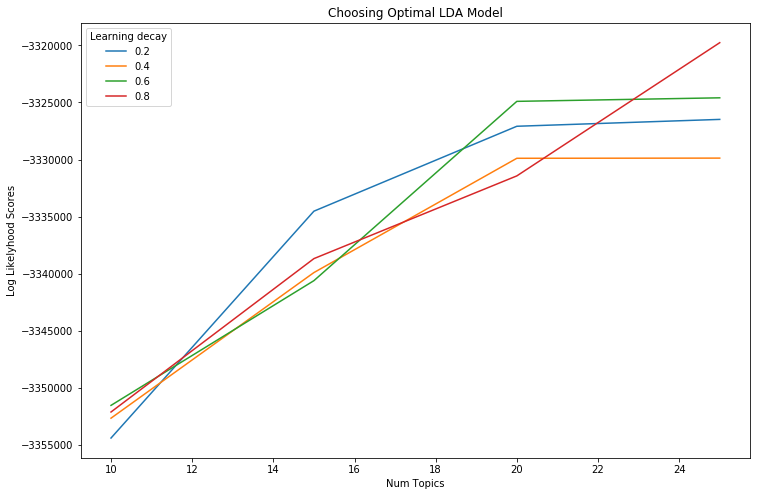

In [55]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25]
log_likelyhoods_2 = model.cv_results_['mean_test_score'][:4]

log_likelyhoods_4 = model.cv_results_['mean_test_score'][4:8]

log_likelyhoods_6 = model.cv_results_['mean_test_score'][8:12]

log_likelyhoods_8 = model.cv_results_['mean_test_score'][12:16]

import matplotlib.pyplot as plt
%matplotlib inline
# Plot
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_2, label='0.2')
# plt.plot(n_topics, log_likelyhoods_3, label='0.3')
plt.plot(n_topics, log_likelyhoods_4, label='0.4')
# plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_6, label='0.6')
# plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_8, label='0.8')
# plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


In [58]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,dominant_topic
Doc0,0,0,0,0,0.27,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0.04,0.68,0,0,22
Doc1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.68,0.27,0,0,0,0,0,0,17
Doc2,0,0,0,0,0,0,0,0,0,0,0,0,0.54,0,0,0,0,0,0,0.43,0,0,0,0,0,12
Doc3,0.04,0,0,0,0.22,0,0,0,0.03,0,0,0,0.1,0,0.06,0,0.01,0.03,0,0.23,0,0,0.22,0,0.06,19
Doc4,0,0,0,0,0,0,0,0,0,0,0,0,0.99,0,0,0,0,0,0,0,0,0,0,0,0,12
Doc5,0,0.17,0,0.02,0,0.08,0.03,0.12,0,0,0.04,0,0,0,0,0,0,0.07,0.47,0,0,0,0,0,0,18
Doc6,0,0,0.04,0,0.32,0,0.33,0,0,0,0,0,0,0,0.07,0,0,0,0,0,0,0,0.23,0,0,6
Doc7,0,0.12,0,0,0,0,0,0,0,0,0,0.03,0,0,0.78,0,0,0,0,0,0,0,0.06,0,0,14
Doc8,0,0,0,0.18,0,0,0,0.24,0,0,0,0,0,0,0,0,0,0,0.15,0,0.41,0,0,0,0,20
Doc9,0,0,0,0,0.26,0.65,0,0,0,0,0.07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


In [60]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic #', 'Number Of Documents']
df_topic_distribution

,Topic #,Number Of Documents
0,4,1274
1,1,812
2,22,747
3,14,718
4,21,661
5,7,656
6,18,574
7,5,510
8,19,498
9,17,400


In [66]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, tf, tf_vectorizer, mds='tsne')
panel

/Users/jr/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      20.155819 -57.173019       1        1  14.310189
22      7.297679  55.679317       2        1   7.228706
1     -44.403408 -35.060707       3        1   5.575298
21     61.627186  50.145855       4        1   5.308651
7     -24.043596  71.767593       5        1   5.088289
19    -18.729210  42.471619       6        1   5.029938
18     36.474743 -10.410949       7        1   4.954943
14     25.724398  14.628201       8        1   4.694048
5     -66.367912   8.679382       9        1   4.621157
20     67.210655 -11.438574      10        1   3.865435
9     -15.648763  11.027308      11        1   3.759766
3       6.319647  85.265190      12        1   3.717639
12     14.182978 -28.545023      13        1   3.318189
15     80.208130  20.851675      14        1   3.176813
2       4.316583  28.404514      15        1   3.143624
17    -38.945759  -5.588543      16        1   2.846649
16      6.905583  -2.508142      17        1   2.800160
24     48.214993 -38.578274      18        1   2.787236
0      32.016319  41.496376      19        1   2.199416
8     -14.280901 -19.712751      20        1   2.195460
23    -12.976874 -49.767090      21        1   2.183074
6      51.376163  17.654394      22        1   2.159770
10     37.276192  72.073235      23        1   2.024194
11    -39.964119  24.611134      24        1   1.963530
13    -51.636059  52.192486      25        1   1.047825, topic_info=     Category          Freq            Term         Total  loglift  logprob
term                                                                       
23    Default   7982.000000            2019   7982.000000  30.0000  30.0000
771   Default  14443.000000            said  14443.000000  29.0000  29.0000
437   Default   9703.000000     information   9703.000000  28.0000  28.0000
243   Default   7763.000000            data   7763.000000  27.0000  27.0000
377   Default   4354.000000          google   4354.000000  26.0000  26.0000
923   Default   4062.000000           trump   4062.000000  25.0000  25.0000
682   Default   3679.000000           prime   3679.000000  24.0000  24.0000
706   Default   3695.000000      publishing   3695.000000  23.0000  23.0000
801   Default   5778.000000         service   5778.000000  22.0000  22.0000
784   Default   3037.000000          school   3037.000000  21.0000  21.0000
203   Default   4858.000000         company   4858.000000  20.0000  20.0000
193   Default   6023.000000             com   6023.000000  19.0000  19.0000
940   Default   9561.000000             use   9561.000000  18.0000  18.0000
783   Default   2220.000000         scholar   2220.000000  17.0000  17.0000
979   Default   2670.000000           women   2670.000000  16.0000  16.0000
400   Default   2612.000000          health   2612.000000  15.0000  15.0000
540   Default   2686.000000       materials   2686.000000  14.0000  14.0000
177   Default   2757.000000        children   2757.000000  13.0000  13.0000
424   Default   3196.000000          images   3196.000000  12.0000  12.0000
66    Default   2503.000000       agreement   2503.000000  11.0000  11.0000
802   Default   3917.000000        services   3917.000000  10.0000  10.0000
536   Default   2697.000000          market   2697.000000   9.0000   9.0000
674   Default   3261.000000       president   3261.000000   8.0000   8.0000
853   Default   4869.000000           state   4869.000000   7.0000   7.0000
640   Default  10848.000000          people  10848.000000   6.0000   6.0000
994   Default   8079.000000            year   8079.000000   5.0000   5.0000
176   Default   2059.000000           child   2059.000000   4.0000   4.0000
220   Default   2329.000000         cookies   2329.000000   3.0000   3.0000
780   Default   5200.000000            says   5200.000000   2.0000   2.0000
663   Default   2284.000000          police   2284.000000   1.0000   1.0000
...       ...